In [11]:
import pandas as pd
# ML and Visualization Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Step 1: Load & Clean Data
# -------------------------
# Load CSV
df = pd.read_csv("../Data/Data Collection.csv")

# Clean column names
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace('\n', ' ').str.replace('\r', ' ')

# Rename only the required columns
df = df.rename(columns={
    "Hobby_top1": "hobby_top1",
    "Hobby_top1  ": "hobby_top1",
    "Club top1": "club_top1",
    "Club top1  ": "club_top1",
    "Reads Books": "reads_books",
    "Reads Books   ": "reads_books",
    "Weekly_hobby_hours     provide values integer between between 0-40": "weekly_hobby_hours"
})

# Keep only relevant columns
df = df[["hobby_top1", "club_top1", "reads_books", "weekly_hobby_hours"]]

# -------------------------------
# Clean weekly_hobby_hours column
# -------------------------------
df["weekly_hobby_hours"] = (
    df["weekly_hobby_hours"]
    .astype(str)                           # ensure string
    .str.lower()                           # lowercase
    .str.replace("hrs", "", regex=False)   # remove 'hrs'
    .str.replace("hours", "", regex=False) # remove 'hours'
    .str.replace("hour", "", regex=False)  # remove 'hour'
    .str.strip()                           # remove spaces
)

# Replace empty strings with 0
df["weekly_hobby_hours"] = df["weekly_hobby_hours"].replace("", "0")

# Convert to integer safely
df["weekly_hobby_hours"] = pd.to_numeric(df["weekly_hobby_hours"], errors="coerce").fillna(0).astype(int)

print("Unique values in weekly_hobby_hours:", df["weekly_hobby_hours"].unique())
print(df.head())


Unique values in weekly_hobby_hours: [ 0 40  5 10 25  4 38 20  2  9  1 14  7 18 28 30 15  3  8 35 13 16  6 33]
  hobby_top1              club_top1 reads_books  weekly_hobby_hours
0    Cricket          Robotics Club          No                   0
1     Coding            Coding Club   Sometimes                  40
2    Cricket            Coding Club   Sometimes                   5
3    Cricket  Entrepreneurship Cell   Sometimes                  10
4  Badminton          Literary Club   Regularly                   5


In [2]:
print("Current DataFrame columns:", df.columns.tolist())


Current DataFrame columns: ['hobby_top1', 'club_top1', 'reads_books', 'weekly_hobby_hours']


In [13]:
# -------------------------
# Step 2: Encode Categorical Columns
# -------------------------

# Map reads_books to numeric
mapping = {"No": 0, "Sometimes": 1, "Regularly": 2}
df["reads_books"] = df["reads_books"].replace(mapping).astype(int)

# One-hot encode hobby_top1 and club_top1
df_encoded = pd.get_dummies(
    df,
    columns=["hobby_top1", "club_top1"],  # encode only these
    drop_first=False,
    dtype=int
)

print("Final dataset shape:", df_encoded.shape)
print(df_encoded.head())


Final dataset shape: (111, 23)
   reads_books  weekly_hobby_hours  hobby_top1_Badminton  hobby_top1_Coding  \
0            0                   0                     0                  0   
1            1                  40                     0                  1   
2            1                   5                     0                  0   
3            1                  10                     0                  0   
4            2                   5                     1                  0   

   hobby_top1_Cricket  hobby_top1_Dance  hobby_top1_Debate  \
0                   1                 0                  0   
1                   0                 0                  0   
2                   1                 0                  0   
3                   1                 0                  0   
4                   0                 0                  0   

   hobby_top1_Football  hobby_top1_Gym  hobby_top1_Hackathons  ...  \
0                    0               0             

C:\Users\ruman\AppData\Local\Temp\ipykernel_5420\2795654681.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["reads_books"] = df["reads_books"].replace(mapping).astype(int)


In [14]:
# -------------------------
# Step 3: Train-Test Split
# -------------------------

# Features (X) = all columns except weekly_hobby_hours
X = df_encoded.drop("weekly_hobby_hours", axis=1)
y = df_encoded["weekly_hobby_hours"]

# Split into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (88, 22)
Testing set shape: (23, 22)


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10]
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring="r2", n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5]
}
gb_grid = GridSearchCV(gb, gb_params, cv=3, scoring="r2", n_jobs=-1)
gb_grid.fit(X_train, y_train)

# Evaluation function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name} Results (Best Params: {model.best_params_}):")
    print(f" MAE  : {mae:.2f}")
    print(f" MSE  : {mse:.2f}")
    print(f" RMSE : {rmse:.2f}")
    print(f" R²   : {r2:.4f}")
    return model.best_estimator_

best_rf = evaluate_model("Random Forest", rf_grid, X_test, y_test)
best_gb = evaluate_model("Gradient Boosting", gb_grid, X_test, y_test)



Random Forest Results (Best Params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 300}):
 MAE  : 9.27
 MSE  : 124.35
 RMSE : 11.15
 R²   : 0.1112

Gradient Boosting Results (Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}):
 MAE  : 9.72
 MSE  : 142.88
 RMSE : 11.95
 R²   : -0.0212



Random Forest (Tuned) Results:
 MAE  : 9.27
 MSE  : 124.35
 RMSE : 11.15
 R²   : 0.1112

Gradient Boosting (Tuned) Results:
 MAE  : 9.72
 MSE  : 142.88
 RMSE : 11.95
 R²   : -0.0212

Ensemble (RF + GB) Results:
 MAE  : 9.46
 MSE  : 129.63
 RMSE : 11.39
 R²   : 0.0735


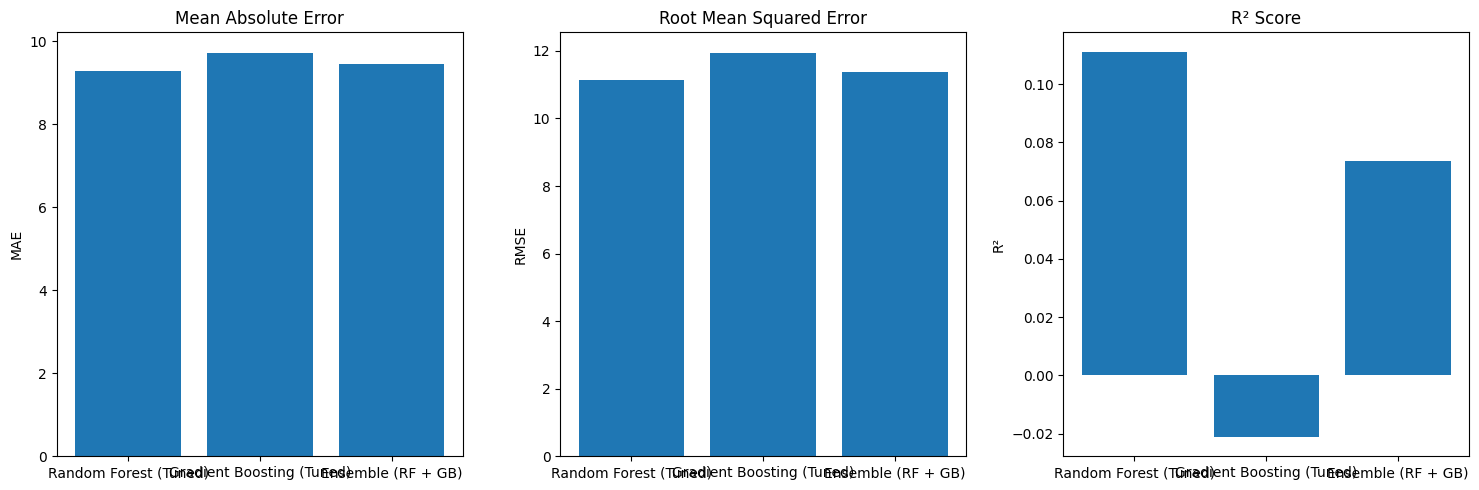

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Train Tuned Models
# -------------------------------
rf_best = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_split=10,
    random_state=42
)
rf_best.fit(X_train, y_train)

gb_best = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_best.fit(X_train, y_train)

# -------------------------------
# 2. Predictions
# -------------------------------
rf_pred = rf_best.predict(X_test)
gb_pred = gb_best.predict(X_test)

# Simple Ensemble (average of RF + GB)
ensemble_pred = (rf_pred + gb_pred) / 2

# -------------------------------
# 3. Evaluation Function
# -------------------------------
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Results:")
    print(f" MAE  : {mae:.2f}")
    print(f" MSE  : {mse:.2f}")
    print(f" RMSE : {rmse:.2f}")
    print(f" R²   : {r2:.4f}")
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}

results = []
results.append(evaluate_model("Random Forest (Tuned)", y_test, rf_pred))
results.append(evaluate_model("Gradient Boosting (Tuned)", y_test, gb_pred))
results.append(evaluate_model("Ensemble (RF + GB)", y_test, ensemble_pred))

# -------------------------------
# 4. Compare in Bar Chart
# -------------------------------
results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 3, figsize=(15,5))

# MAE
axes[0].bar(results_df["Model"], results_df["MAE"])
axes[0].set_title("Mean Absolute Error")
axes[0].set_ylabel("MAE")

# RMSE
axes[1].bar(results_df["Model"], results_df["RMSE"])
axes[1].set_title("Root Mean Squared Error")
axes[1].set_ylabel("RMSE")

# R²
axes[2].bar(results_df["Model"], results_df["R2"])
axes[2].set_title("R² Score")
axes[2].set_ylabel("R²")

plt.tight_layout()
plt.show()


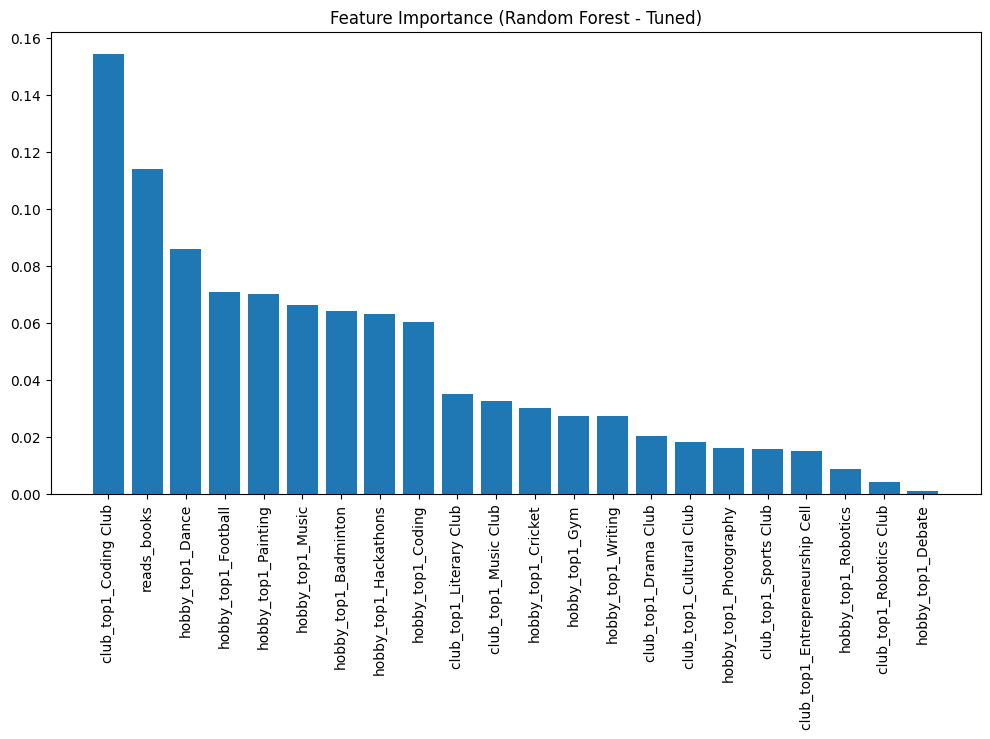

In [17]:
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.title("Feature Importance (Random Forest - Tuned)")
plt.show()



Random Forest (Tuned) Results:
 MAE  : 9.27
 MSE  : 124.35
 RMSE : 11.15
 R²   : 0.1112

Gradient Boosting (Tuned) Results:
 MAE  : 9.72
 MSE  : 142.88
 RMSE : 11.95
 R²   : -0.0212

Ensemble (RF + GB) Results:
 MAE  : 9.46
 MSE  : 129.63
 RMSE : 11.39
 R²   : 0.0735


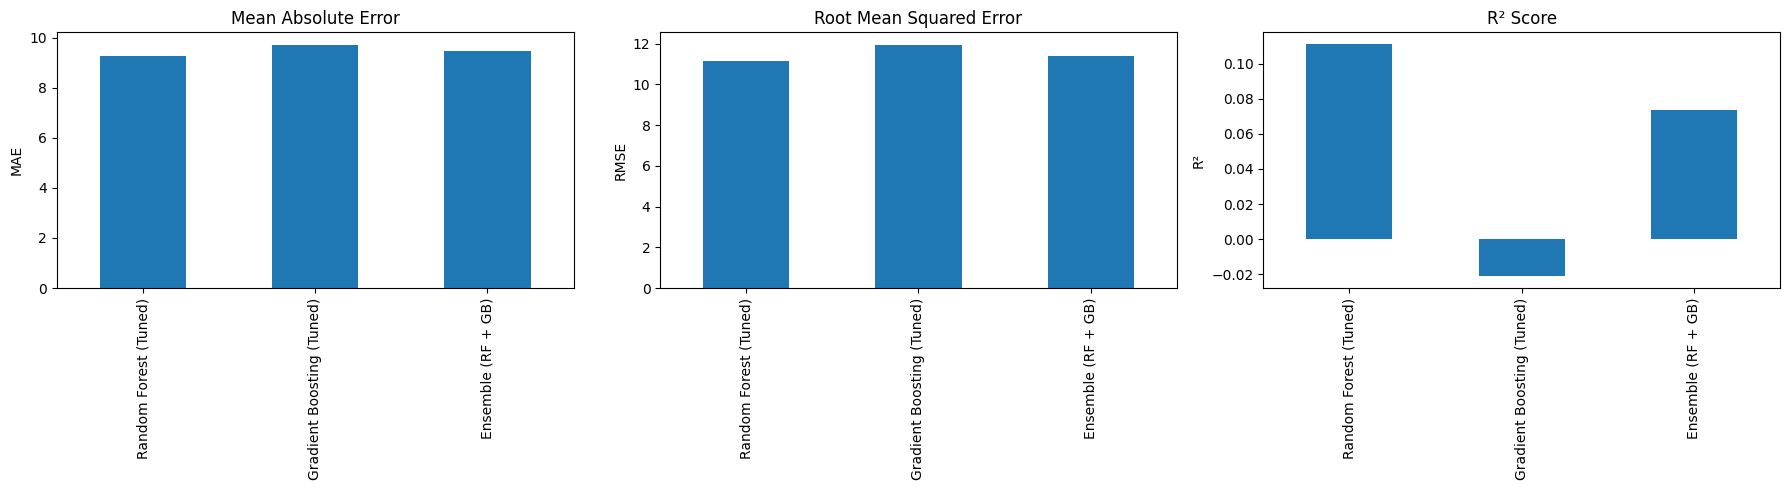

In [18]:
# -------------------------------
# Step 6: Ensemble (Voting Regressor) & Model Comparison
# -------------------------------
from sklearn.ensemble import VotingRegressor

# Create ensemble model
ensemble = VotingRegressor([
    ("rf", best_rf),
    ("gb", best_gb)
])

ensemble.fit(X_train, y_train)

# -------------------------------
# Evaluate Models
# -------------------------------
models = {
    "Random Forest (Tuned)": best_rf,
    "Gradient Boosting (Tuned)": best_gb,
    "Ensemble (RF + GB)": ensemble
}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = [mae, mse, rmse, r2]

    print(f"\n{name} Results:")
    print(f" MAE  : {mae:.2f}")
    print(f" MSE  : {mse:.2f}")
    print(f" RMSE : {rmse:.2f}")
    print(f" R²   : {r2:.4f}")

# -------------------------------
# Comparison Plot
# -------------------------------
results_df = pd.DataFrame(results, index=["MAE", "MSE", "RMSE", "R²"]).T

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE
results_df["MAE"].plot(kind="bar", ax=axes[0], title="Mean Absolute Error")
axes[0].set_ylabel("MAE")

# RMSE
results_df["RMSE"].plot(kind="bar", ax=axes[1], title="Root Mean Squared Error")
axes[1].set_ylabel("RMSE")

# R²
results_df["R²"].plot(kind="bar", ax=axes[2], title="R² Score")
axes[2].set_ylabel("R²")

plt.tight_layout()
plt.show()


In [19]:
# -------------------------------
# Step 7: Deployment / Prediction Demo
# -------------------------------
import joblib

# 1. Save the best model (Random Forest)
joblib.dump(best_rf, "best_model_rf.pkl")
print("✅ Random Forest model saved as best_model_rf.pkl")

# 2. Load model later (for deployment use)
model = joblib.load("best_model_rf.pkl")

# 3. Prediction function
def predict_hobby_hours(hobby, club, reads_books):
    # Create dataframe for input
    new_data = pd.DataFrame({
        "hobby_top1": [hobby],
        "club_top1": [club],
        "reads_books": [reads_books]
    })

    # Apply same encoding as training
    new_data_encoded = pd.get_dummies(new_data, columns=["hobby_top1", "club_top1"], drop_first=False, dtype=int)

    # Align columns with training data
    new_data_encoded = new_data_encoded.reindex(columns=X_train.columns, fill_value=0)

    # Predict
    prediction = model.predict(new_data_encoded)[0]
    print(f"Predicted weekly hobby hours for {hobby} + {club} (Reads books={reads_books}): {prediction:.2f}")
    return prediction

# Example predictions
predict_hobby_hours("Dance", "Coding Club", 1)
predict_hobby_hours("Football", "Sports Club", 0)


✅ Random Forest model saved as best_model_rf.pkl
Predicted weekly hobby hours for Dance + Coding Club (Reads books=1): 18.73
Predicted weekly hobby hours for Football + Sports Club (Reads books=0): 15.78


np.float64(15.779581299890715)

In [16]:
df

,hobby_top1,club_top1,reads_books,weekly_hobby_hours
0,Cricket,Robotics Club,No,0
1,Coding,Coding Club,Sometimes,40
2,Cricket,Coding Club,Sometimes,5
3,Cricket,Entrepreneurship Cell,Sometimes,10
4,Badminton,Literary Club,Regularly,5
...,...,...,...,...
105,Painting,Drama Club,Sometimes,10
106,Gym,Entrepreneurship Cell,Sometimes,33
107,Cricket,Sports Club,No,5
109,Cricket,Sports Club,Sometimes,0


In [9]:
import joblib

# Save both models
joblib.dump(rf_best, "random_forest_model.pkl")
joblib.dump(gb_best, "gradient_boosting_model.pkl")

# Save ensemble logic (just average predictions)
def ensemble_predict(X):
    rf_pred = rf_best.predict(X)
    gb_pred = gb_best.predict(X)
    return (rf_pred + gb_pred) / 2

joblib.dump(ensemble_predict, "ensemble_model.pkl")

print("✅ Models saved successfully!")


✅ Models saved successfully!


In [10]:
rf_loaded = joblib.load("random_forest_model.pkl")
gb_loaded = joblib.load("gradient_boosting_model.pkl")
ensemble_loaded = joblib.load("ensemble_model.pkl")

# Example prediction
new_pred = ensemble_loaded(X_test[:5])  
print(new_pred)


[18.96616377  8.44028752 10.10520099 14.80487269 12.07909066]
